# Generate Data

In [17]:
class Kernel:
    def __init__(self, tau_sqr, sigma):
        # generally ARD. If isotropic then all tau_sqr equal.
        self.tau_sqr = np.diag(tau_sqr)
        self.sigma = sigma

    def __call__(self, X):
        n, d = X.shape

        if self.tau_sqr.shape != (d, d):
            raise ValueError("tau should be a square matrix with dimensions (d, d).")

        K = np.zeros((n, n))
        A = np.linalg.solve(self.tau_sqr, np.eye(d))

        for i in range(n):
            for j in range(i,n):
                diff = X[i] - X[j]
                K[i, j] = self.sigma * np.exp(-0.5 * (diff.T @ A @ diff))
                K[j, i] = K[i, j]

        return K

In [18]:
import numpy as np
from scipy.special import erf
from scipy.stats import t


df = np.inf # try probit first

def generate_gp_classification_data(kernel, n_samples, n_features, noise=1e-6):
    
    np.random.seed(42) #to ensure that same data generated 
    
    # for simplicity choose (-1, 1) as range for now
    X = np.random.uniform(-1., 1., (n_samples, n_features))

    K = kernel(X) + noise * np.eye(n_samples)  # Add small noise for numerical stability

    f = np.random.multivariate_normal(np.zeros(n_samples), K)

    #p = 0.5 * (1 + erf(f / np.sqrt(2)))
    #try robit
    p = t.cdf(f, df=df)


    y = np.random.binomial(1, p) * 2 - 1 # y in -1, 1

    return X, y

In [101]:
# generate data
d = 2
n = 50

#initialize hyperparameters from prior
# isotropic
#tau = np.random.gamma(1, 1/np.sqrt(d))
tau = 0.35
sigma = 2.08
tau_sqr = np.ones(d) * tau**2
#sigma = np.random.gamma(1.2, .2)

#initialize kernel
kernel_init = Kernel(tau_sqr, sigma)

#generate synthesized data
X_generated, y_generated = generate_gp_classification_data(kernel_init, n, d)

In [102]:
generate_data = True
if generate_data:
    X = X_generated
    y = y_generated

# Distribution class

In [21]:
class Distribution:
    def sample(self, *args, **kwargs):
        """
        Generate samples from the distribution.
        Args can include specific parameters for the distribution.
        """
        raise NotImplementedError("Sample method must be implemented by subclasses.")

    def pdf(self, x, *args, **kwargs):
        """
        Evaluate the probability density (or mass) function at x.
        Args can include specific parameters for the distribution.
        """
        raise NotImplementedError("PDF method must be implemented by subclasses.")

In [22]:
class MultivariateGaussian(Distribution):
    def __init__(self, mean, covariance):
        """
        Initialize a Multivariate Gaussian distribution.

        :param mean: Mean vector (1D numpy array).
        :param covariance: Covariance matrix (2D numpy array).
        """
        self.mean = np.asarray(mean)
        self.covariance = np.asarray(covariance)
        self.dim = self.mean.shape[0]

        # Precompute useful quantities
        self.inv_cov = np.linalg.inv(self.covariance + 1e-8 * np.eye(self.dim))  # Regularized inversion
        self.log_det_cov = np.linalg.slogdet(self.covariance)[1]
        #self.log_det_cov = np.log1p(np.linalg.det(self.covariance + 1e-8 * np.eye(self.dim)))  # Log determinant
        self.normalizer = -0.5 * (self.dim * np.log(2 * np.pi) + self.log_det_cov)  # Log normalization constant

    def sample(self, size=1):
        """
        Generate samples from the multivariate Gaussian distribution.

        :param size: Number of samples to generate.
        :return: Samples as a numpy array of shape (size, dim).
        """
        return np.random.multivariate_normal(self.mean, self.covariance, size)

    def pdf(self, x):
        """
        Evaluate the probability density function at x.

        :param x: A point or array of points where the PDF is evaluated (numpy array of shape (dim,) or (n, dim)).
        :return: PDF value(s) as a scalar or numpy array.
        """
        return np.exp(self.log_pdf(x))

    def log_pdf(self, x):
        """
        Evaluate the log of the probability density function at x.

        :param x: A point or array of points where the log PDF is evaluated (numpy array of shape (dim,) or (n, dim)).
        :return: Log PDF value(s) as a scalar or numpy array.
        """
        x = np.atleast_2d(x)
        diff = x - self.mean
        exponent = -0.5 * np.sum(diff @ self.inv_cov * diff, axis=1)  # Quadratic form
        return exponent + self.normalizer

In [23]:
from scipy.stats import gamma

class MultivariateGammaDistribution(Distribution):
    def __init__(self, shape, scale):
        """
        Initialize the multivariate independent Gamma distribution with given shape and scale.

        :param shape: Shape parameters (α) of the Gamma distributions for each dimension.
        :param scale: Scale parameters (β) of the Gamma distributions for each dimension.
        """
        self.shape = np.array(shape)  # Shape parameters (α) for each dimension
        self.scale = np.array(scale)  # Scale parameters (β) for each dimension
        self.d = len(shape)  # Number of dimensions

    def sample(self, size=1):
        """
        Generate random samples from the independent Gamma distributions for each dimension.

        :param size: The number of samples to generate.
        :return: Samples from the independent Gamma distributions.
        """
        samples = np.zeros((size, self.d))
        for i in range(self.d):
            samples[:, i] = gamma.rvs(self.shape[i], scale=self.scale[i], size=size)
        return samples

    def pdf(self, x):
        """
        Evaluate the probability density function (PDF) of the independent Gamma distributions.

        :param x: Points at which to evaluate the PDF (shape (n, d), n samples and d dimensions).
        :return: Probability density function values (shape (n,)).
        """
        pdf_values = np.ones(x.shape[0])
        for i in range(self.d):
            pdf_values *= gamma.pdf(x[:, i], self.shape[i], scale=self.scale[i])
        return pdf_values

    def log_pdf(self, x):
        """
        Evaluate the log of the probability density function (PDF) of the independent Gamma distributions.

        :param x: Points at which to evaluate the log PDF.
        :return: Log of the probability density function values.
        """
        log_pdf_values = np.zeros(x.shape[0])
        for i in range(self.d):
            log_pdf_values += gamma.logpdf(x[:, i], self.shape[i], scale=self.scale[i])
        return log_pdf_values

    def mean(self):
        """
        Compute the mean of the independent Gamma distributions for each dimension.

        :return: The mean of the distribution (shape (d,)).
        """
        return self.shape * self.scale

    def variance(self):
        """
        Compute the variance of the independent Gamma distributions for each dimension.

        :return: The variance of the distribution (shape (d,)).
        """
        return self.shape * self.scale**2

In [24]:
from scipy.optimize import minimize
from scipy.stats import t
import numpy as np

class LaplaceApproximation:
    def __init__(self, X, y, df):
        """
        Initialize the Laplace approximation for Gaussian process classification.

        :param X: Input data (n x d).
        :param y: Observed labels (+1 or -1).
        :param kernel: A callable that computes the kernel matrix given input data.
        :param df: Degrees of freedom for the t-distribution (set to np.inf for Gaussian).
        """
        self.X = X
        self.y = y
        self.df = df

    def neg_log_posterior(self, f):
        """
        Compute the negative log-posterior.

        :param f: Latent function values (array).
        :return: Negative log-posterior value.
        """
        # Log-likelihood (Robit model)
        likelihood = -np.sum(np.log(t.cdf(self.y * f, df=self.df)))

        # GP prior term
        prior = 0.5 * f.T @ self.K_inv @ f

        return likelihood + prior

    def grad_neg_log_posterior(self, f):
        """
        Compute the gradient of the negative log-posterior.

        :param f: Latent function values (array).
        :return: Gradient of negative log-posterior.
        """
        # Gradient of log-likelihood
        cdf = t.cdf(self.y * f, df=self.df)
        pdf = t.pdf(self.y * f, df=self.df)
        grad_likelihood = -self.y * pdf / (cdf + 1e-8)

        # Gradient of GP prior term
        grad_prior = self.K_inv @ f

        return grad_likelihood + grad_prior

    def log_posterior_hessian(self, f):
        """
        Compute the Hessian of the log Gaussian CDF or Robit likelihood for GP classification.

        :param f: Latent function values (n x 1).
        :return: Hessian matrix (n x n).
        """
        phi = t.pdf(self.y * f, df=self.df)
        Phi = t.cdf(self.y * f, df=self.df)

        if self.df == np.inf:
            phi_prime = -self.y * f * phi  # Derivative of Gaussian PDF
        else:
            phi_prime = -(self.df + 1) / (self.df + (self.y * f) ** 2) * self.y * f * phi  # Derivative of Student's t PDF

        Phi_safe = np.maximum(Phi, 1e-9)

        first_term = phi / Phi_safe
        second_term = (phi_prime / Phi_safe - (phi / Phi_safe) ** 2)
        hessian_diag = self.y ** 2 * second_term

        H_diag = np.diag(hessian_diag)

        return H_diag - self.K_inv

    def fit(self, kernel):
        """
        Perform the Laplace approximation to find the posterior distribution.

        :return: Multivariate Gaussian posterior proposal.
        """
        f_init = np.zeros(self.X.shape[0])
        K = kernel(self.X)
        assert K.shape == (self.X.shape[0], self.X.shape[0])
        self.K_inv = np.linalg.solve(K + 1e-8 * np.eye(self.X.shape[0]), np.eye(self.X.shape[0]))

        result = minimize(
            self.neg_log_posterior,
            f_init,
            jac=self.grad_neg_log_posterior,
            method='L-BFGS-B',
            options={'maxiter': 200} # set max_iter to control computation complexity
        )

        f_star = result.x
        inv_cov_star = -self.log_posterior_hessian(f_star)
        cov_star = np.linalg.solve(inv_cov_star, np.eye(self.X.shape[0]))

        return MultivariateGaussian(mean=f_star, covariance=cov_star)


# Coupled Pseudo Marginal

In [25]:
import tqdm

class CoupledPseudoMarginal:
    def __init__(self, proposal_theta, prior_theta, X, y, df, Nimp, num_group):
        """
        Initialize the Coupled Pseudo-marginal Metropolis-Hastings algorithm with proposal and prior functions.

        :param proposal_theta: Proposal distribution for θ (a Distribution object).
        :param prior_theta: Prior distribution for θ (a Distribution object).
        :param X: Data matrix.
        :param y: Target vector.
        :param Nimp: Number of importance samples Nimp.
        :param num_group: Number of groups for MoM estimator.
        """
        self.proposal_theta = proposal_theta
        self.prior_theta = prior_theta
        self.Nimp = Nimp
        self.X = X
        self.y = y
        self.num_group = num_group
        self.df = df
        self.laplace = LaplaceApproximation(self.X, self.y, self.df)

    def transition(self, theta, theta_mom, estimator, estimator_mom, log_weight, ess, ess_mom):
        """
        Perform one step of the coupled pseudo-marginal Metropolis-Hastings algorithm.

        :param theta: Current value of theta.
        :param estimator_pm: Current value of the pseudo-marginal estimator.
        :param estimator_mom: Current value of the MoM estimator.
        :return: A tuple of (new_theta, new_estimator_pm, new_estimator_mom, acceptance flag).
        """
        theta_noise = self.proposal_theta.sample()
        log_theta = np.log(theta)
        log_theta_mom = np.log(theta_mom)
        log_theta_new = log_theta + theta_noise
        log_theta_new_mom = log_theta_mom + theta_noise
        theta_new = np.exp(log_theta_new)
        theta_new_mom = np.exp(log_theta_new_mom)

        _, estimator_new, ess_new = self.MoM_sampler(theta_new)
        estimator_mom_new, estimator_correction, ess_mom_new = self.MoM_sampler(theta_new_mom)
        log_weight_new = np.log(estimator_correction) - np.log(estimator_mom_new)

        # Calculate the acceptance probability for importance sampling
        log_accept_prob_new = self.proposal_theta.log_pdf(log_theta_new - log_theta) + self.prior_theta.log_pdf(theta_new) + np.log(estimator_new)
        log_accept_prob_old = self.proposal_theta.log_pdf(log_theta - log_theta_new) + self.prior_theta.log_pdf(theta) + np.log(estimator)
        A = min(0, log_accept_prob_new - log_accept_prob_old)

        # for mom
        log_accept_prob_new_mom = self.proposal_theta.log_pdf(log_theta_new_mom - log_theta_mom) + self.prior_theta.log_pdf(theta_new_mom) + np.log(estimator_mom_new)
        log_accept_prob_old_mom = self.proposal_theta.log_pdf(log_theta_mom - log_theta_new_mom) + self.prior_theta.log_pdf(theta_mom) + np.log(estimator_mom)
        A_mom = min(0, log_accept_prob_new_mom - log_accept_prob_old_mom)

        u = np.random.uniform(0, 1)
        if A > np.log(u):
            is_return = [theta_new, estimator_new, True, ess_new]
        else:
            is_return =  [theta, estimator, False, ess]

        if A_mom > np.log(u):
            mom_return = [theta_new_mom, estimator_mom_new, True, log_weight_new, ess_mom_new]
        else:
            mom_return = [theta_mom, estimator_mom, False, log_weight, ess_mom]

        return is_return, mom_return


    def MoM_sampler(self, theta, proposal_f = None):
        """
        Generate importance samples for the likelihood function using importance sampling.

        :param theta: Hyperparameters for the GP kernel.
        :return: Importance-weighted estimator.
        """
        theta = theta.flatten()
        tau_sqr = theta[:-1] ** 2
        sigma = theta[-1]

        # Kernel and covariance

        kernel = Kernel(tau_sqr=tau_sqr, sigma=sigma)
        K = kernel(self.X)
        K = (K.T + K)/2 + np.eye(K.shape[0])*1e-8 # ensure psd
        model_dist_f = MultivariateGaussian(mean=np.zeros(self.X.shape[0]), covariance=K)

        # Proposal distribution
        if proposal_f is None:
            proposal_f = self.laplace.fit(kernel)

        f_samples = proposal_f.sample(self.Nimp)

        # Likelihoods
        likelihood_y = t.cdf(self.y * f_samples, df=self.df).prod(axis=1) # student t CDF
        #likelihood_y_log = np.log1p(likelihood_y)

        likelihood_f_log = model_dist_f.log_pdf(f_samples)
        proposal_likelihood_f_log = proposal_f.log_pdf(f_samples)



        # Compute estimator in log-space
        log_weights = likelihood_f_log - proposal_likelihood_f_log
        weights = np.exp(log_weights - np.max(log_weights))
        weights = weights / np.sum(weights)
        ess = 1/np.sum(weights**2)
        is_estimator = np.sum(weights * likelihood_y)

        log_weights_split = np.array_split(log_weights, self.num_group)
        likelihood_y_split = np.array_split(likelihood_y, self.num_group)
        means = []
        for i in range(self.num_group):
            group_weights = np.exp(log_weights_split[i]- np.max(log_weights_split[i]))
            group_weights = group_weights / np.sum(group_weights)
            estimator = np.sum(group_weights * likelihood_y_split[i])
            means.append(estimator)
        mom_estimator = np.median(means)
        print(is_estimator, mom_estimator)

        return mom_estimator, is_estimator, ess


    def run(self, theta_0, n_iter):
        """
        Run the coupled pseudo-marginal Metropolis-Hastings algorithm for n_iter iterations.

        :param theta_0: Initial value for theta.
        :param estimator_pm_0: Initial value for the pseudo-marginal estimator.
        :param estimator_mom_0: Initial value for the MoM estimator.
        :param n_iter: Number of iterations.
        :return: Results for both estimators and acceptance rate.
        """
        theta = theta_0
        theta_mom = theta_0
        estimator, estimator_mom, ess = self.MoM_sampler(theta_0)
        log_weight = np.log(estimator) - np.log(estimator_mom)
        ess_mom = ess

        thetas = []
        thetas_mom = []
        estimators = []
        estimators_mom = []
        log_weights = []
        ess_list = []
        ess_mom_list = []
        sum_acceptance = 0
        sum_acceptance_mom = 0

        for _ in tqdm.tqdm(range(n_iter)):
            is_return, mom_return = self.transition(theta, theta_mom, estimator, estimator_mom, log_weight, ess, ess_mom)

            theta = is_return[0]
            estimator = is_return[1]
            theta_mom = mom_return[0]
            estimator_mom = mom_return[1]
            log_weight = mom_return[3]
            ess = is_return[3]
            ess_mom = mom_return[4]

            thetas.append(theta)
            estimators.append(estimator)
            ess_list.append(ess)
            if is_return[2]:
                sum_acceptance += 1

            thetas_mom.append(theta_mom)
            estimators_mom.append(estimator_mom)
            ess_mom_list.append(ess_mom)
            log_weights.append(log_weight)
            if mom_return[2]:
                sum_acceptance_mom += 1

        acceptance_rate = sum_acceptance / n_iter
        acceptance_rate_mom = sum_acceptance_mom / n_iter

        return np.array(thetas), np.array(estimators), acceptance_rate, np.array(thetas_mom), np.array(estimators_mom), acceptance_rate_mom, np.array(log_weights), np.array(ess_list), np.array(ess_mom_list)

# N = 50, d = 2

## get initialization

In [ ]:
# prior for (\tau, \sigma)
shape = np.concatenate([np.ones(d), [1.2]])
scale = np.concatenate([np.ones(d) * (np.sqrt(d)), [1./0.2]])
theta_prior = MultivariateGammaDistribution(shape=shape, scale=scale)
proposal_theta = MultivariateGaussian(mean=np.zeros(d+1), covariance= .5 * np.eye(d+1))

#theta_0 = theta_prior.sample()
tau = .35
tau_sqr = np.ones(d) * tau ** 2
theta_0 = np.concatenate([tau_sqr, [sigma]]).reshape((1, d + 1))

pm_coupling_try = CoupledPseudoMarginal(proposal_theta, theta_prior, X, y,df, 64,4)
thetas, estimators, acceptance_rate, thetas_mom, estimators_mom, acceptance_rate_mom, log_weights, ess_list, ess_mom_list = pm_coupling_try.run(theta_0, 500)

In [130]:
print(' acceptance rate for pseudo marginal is:', acceptance_rate)
print(' acceptance rate for MoM is:', acceptance_rate_mom)

 acceptance rate for pseudo marginal is: 0.112
 acceptance rate for MoM is: 0.256


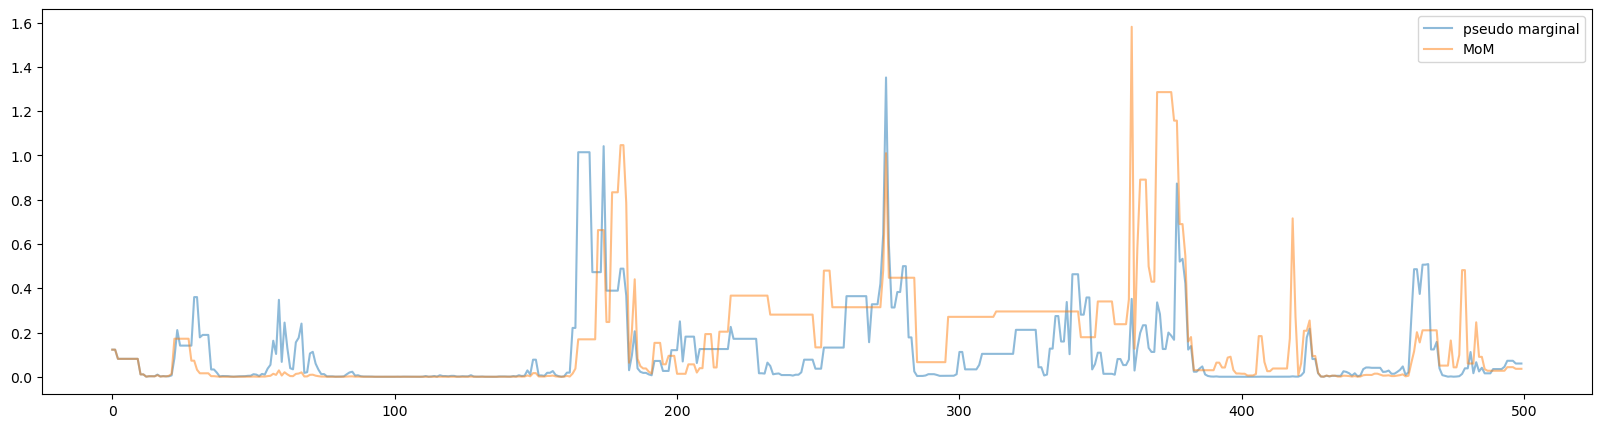

In [116]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(thetas[:,:,1], alpha=.5, label='pseudo marginal')
plt.plot(thetas_mom[:,:,1], alpha=.5, label='MoM')
plt.legend()
plt.show()

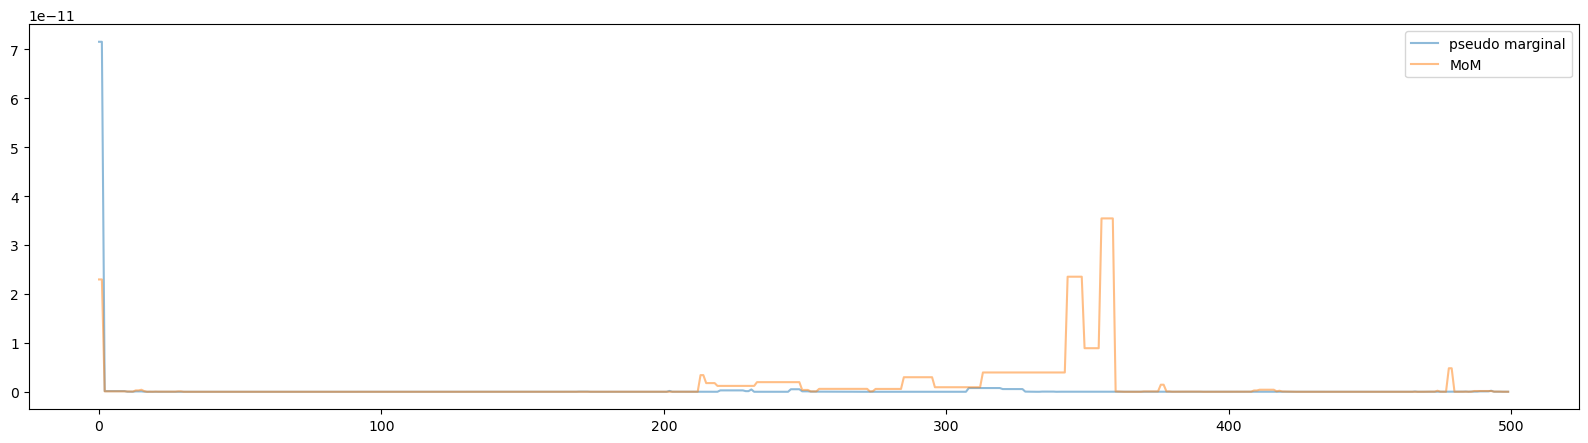

In [117]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(estimators, alpha=.5, label='pseudo marginal')
plt.plot(estimators_mom, alpha=.5, label='MoM')
plt.legend()
plt.show()

In [121]:
initial_theta = theta_0


## run chains in parallel

In [ ]:
from joblib import Parallel, delayed

# Example function to run in parallel
def run_chain(i):
    # Replace this with your actual function or task
    thetas, estimators, acceptance_rate, thetas_mom, estimators_mom, acceptance_rate_mom, log_weights, ess_list, ess_mom_list = pm_coupling_try.run(initial_theta, 15000)
    return thetas, estimators, acceptance_rate, thetas_mom, estimators_mom, acceptance_rate_mom, log_weights, ess_list, ess_mom_list

# Parallel execution with Joblib
n_chains = 200
n_jobs = 10

results = Parallel(n_jobs=n_jobs)(delayed(run_chain)(i) for i in range(n_chains))

all_thetas = []
all_estimators = []
all_acceptance_rates = []
all_thetas_mom = []
all_estimators_mom = []
all_acceptance_rates_mom = []
all_log_weights = []
all_ess = []
all_ess_mom = []

for i in range(n_chains):
    thetas, estimators, acceptance_rate, thetas_mom, estimators_mom, acceptance_rate_mom, log_weights, ess_list, ess_mom_list = results[i]
    all_thetas.append(thetas)
    all_estimators.append(estimators)
    all_acceptance_rates.append(acceptance_rate)
    all_thetas_mom.append(thetas_mom)
    all_estimators_mom.append(estimators_mom)
    all_acceptance_rates_mom.append(acceptance_rate_mom)
    all_log_weights.append(log_weights)
    all_ess.append(ess_list)
    all_ess_mom.append(ess_mom_list)

  0%|          | 1/15000 [00:00<34:00,  7.35it/s]

6.134642536339156e-12 3.7051311610480564e-11


  0%|          | 0/15000 [00:00<?, ?it/s].52it/s]

1.7721028198039694e-12 4.124314727392104e-12
2.6728931066194316e-13 9.040580776961092e-12
7.372440328706753e-12 2.3911318707106473e-11
2.4169358263663646e-11 4.4631738370892975e-11
1.3932554924599488e-11 2.348606780236471e-11
1.1548789062902469e-11 3.458716396921653e-11
3.0998947318479066e-11 3.201667789358098e-11
3.3928078521359374e-12 7.818513103326355e-12


  0%|          | 4/15000 [00:00<24:50, 10.06it/s]

3.577200033353005e-13 3.4306344803644432e-12


  0%|          | 52/15000 [00:05<31:10,  7.99it/s]

3.508588787822555e-11 1.0693068055011189e-09
5.574663034299894e-12 2.684937880533715e-11
1.0321242003753916e-12 4.350551784723733e-11
3.122105547523636e-11 5.7992219834487855e-11
9.354935060291209e-11 2.4117779447602067e-11
2.228854802689814e-11 5.3239647904710046e-11
1.3621860443147146e-11 2.009600719229176e-10
3.0001218298686467e-12 3.3509626841725315e-12
2.2440704154919054e-12 3.13240146551513e-11
3.185383088774414e-11 1.8257395963757986e-11
5.878162174606976e-15 7.720007594634173e-13
5.767620039418783e-10 1.7886301027275682e-10
4.85753420084017e-12 1.90432914428799e-11
1.4235598307957935e-10 1.167801879204635e-10
4.469423707076264e-12 3.033432161060227e-11
4.958326241743074e-12 1.3250959843041824e-10
2.35390717780857e-12 2.6883554889056887e-10
6.890109097860521e-13 1.0783506263211101e-12
2.1628840735301587e-10 8.292692269332128e-10
1.705208405510828e-11 6.535031146121234e-11
3.385909575773338e-13 7.530065203979432e-13
1.143278720876181e-11 1.1550282132219796e-11
8.24786892485739e-1

  0%|          | 45/15000 [00:05<37:54,  6.57it/s]

1.6766228089462734e-13 4.113128079254103e-12
1.4233010784152753e-12 4.035472201486887e-12
8.103595092790496e-12 1.4348182781529405e-11
4.586718442345546e-13 4.6509834496269395e-12
2.7674470008860115e-13 2.7745100795699954e-11
5.847233244995802e-12 3.910518695156636e-11
2.6034916251419798e-12 2.227322484031766e-12
1.973702820855311e-11 6.129190448998474e-11
2.867438526804056e-10 1.3167699098633605e-09
5.233513164190062e-15 4.720301455596221e-11
6.889988128837572e-10 4.39069584996724e-10
1.5495366302340075e-12 1.0573560579558525e-10
3.605067857376195e-11 2.584743316855038e-11
9.67662314025069e-12 1.5020238246182552e-11
2.0657127895810064e-12 2.5200672204297376e-11
1.8167672744437905e-11 2.615136705152818e-10
3.817589027286562e-11 4.235733943603065e-11
1.2159288181774777e-12 7.0893748759168684e-12
6.056415829808377e-10 3.8722898040732614e-10
4.4990851730699215e-10 6.554842331770175e-10
7.010837593056008e-14 1.964565303128481e-12
4.344748923962498e-12 4.147125273369062e-11
2.02017436741771

  0%|          | 66/15000 [00:06<22:36, 11.01it/s]]

1.600589538181921e-11 4.303791689497407e-11
1.3048550563919761e-11 1.329129975665808e-11
2.7988073058056424e-13 6.713538509981901e-13
4.844033979600374e-12 7.69448030892306e-12
6.674081681806834e-11 1.5951969016722847e-10
2.0826273019754842e-12 2.2630600363988686e-12
3.016176148414744e-13 2.6393327294225223e-11
2.4606710184383018e-11 2.957584145998192e-11
1.906528717766347e-11 1.0665970581749516e-10
9.644031992665913e-12 1.9065414159507203e-11
1.6306856032674107e-11 1.8886179314379365e-11
5.578017262872436e-10 4.582369651233345e-10
1.3925921990257775e-10 1.1793061510325246e-10
2.2588529873735107e-11 3.1093427283044623e-11
3.101693043362592e-10 2.049727065806686e-09
1.1357726590777388e-10 2.1942689648339867e-10
5.388763202352569e-13 6.51872169159299e-12
3.736733004488932e-12 8.745687572211151e-11
2.5405404279318086e-13 6.905296485470749e-11
2.34602108907723e-10 1.0716043624765102e-09
1.103054490067565e-09 8.064396515226006e-10
1.640203294983616e-11 2.4508754418918604e-10
4.3634096658546

  0%|          | 71/15000 [00:06<20:19, 12.25it/s]]

3.115498549846657e-12 8.11060597715177e-12
1.0829492683342655e-12 1.8765415208059912e-12
9.061196158639733e-12 1.5973284557796612e-11
1.5275927482438008e-11 2.295091155825286e-11
4.984422158404251e-14 6.288535337396517e-14
3.254255032426709e-15 6.940676713633524e-14
2.530612865232464e-12 3.7411482690888214e-12
9.998881479821646e-13 1.1235500130816061e-12
8.678805184353398e-12 1.1802885937323356e-10
8.36156907504296e-11 1.9783326519987873e-10
1.0831581465382205e-11 2.7447731671020056e-12
1.1338417392621619e-10 1.250889033675048e-09
6.320381421972776e-11 5.562252665450702e-11
4.345638571769327e-10 4.758106066140676e-10
5.961756883425942e-12 1.6383750430432358e-10
5.027128701990546e-10 8.784710232492307e-09
2.085572425927999e-09 2.6201119772449853e-09
1.530084532765069e-09 2.4252342763571263e-09
7.901422548536515e-13 2.4995959265690156e-10
2.492074274006156e-11 1.8932556318169207e-10
1.604511328048531e-10 2.038326338067424e-10
2.335354839273488e-10 3.2815193027694634e-10
2.885763582670460

  1%|          | 93/15000 [00:07<15:05, 16.47it/s]]

6.6424974557832605e-12 3.3195206507036846e-11
5.131433505118191e-12 9.74744973346801e-12
3.1978996026656404e-11 3.4039186367603305e-11
8.997265450911359e-12 5.4643937104358227e-11
4.194278256109563e-12 4.4900934840692215e-12
8.675887787907335e-13 2.734912176460523e-12
8.260309315664296e-13 1.2678472501555937e-12
8.17100911835526e-12 7.887531532769359e-12
3.9218697183723585e-11 2.2320356929281884e-10
2.0052517804544892e-10 9.035004866844981e-10
4.8575604945746954e-11 3.6840377134545376e-11
1.0810951248259351e-10 5.102388111798909e-11
3.903828201597639e-12 5.78105949711264e-12
4.706665652215132e-11 8.650556429415776e-10
1.0113214671818158e-10 1.9917033813026303e-10
6.721229556944701e-11 1.259408432851864e-10
6.426707356417992e-11 1.1387962360691864e-10
1.6514048008929357e-11 1.90952816079436e-11
5.5722167068735227e-14 1.5052816903921794e-12
4.924614740270027e-12 6.401860385645097e-11
3.708137970572136e-14 1.9398315466775924e-13
3.3634015824957964e-09 5.166216142320049e-09
5.6231137338102

  1%|          | 80/15000 [00:08<31:16,  7.95it/s]]

1.0361527160358059e-12 1.094355263359233e-11
7.335901106488077e-11 4.347264478343186e-11
4.5695388198284455e-12 6.5009539729097945e-12
1.529752738291982e-11 1.0844643226012296e-10
1.509666008913502e-13 4.578837758906485e-13
2.1994833377506323e-15 4.122810211689277e-16
3.032133201395249e-13 3.1927250111953195e-13
9.948532717371975e-15 1.847421113568579e-15
7.340616579377725e-13 2.7032816964790455e-12
1.5634356267327034e-12 3.5434315512729333e-12
3.12668739546039e-12 1.194603842563176e-11
1.3347899641292536e-10 3.6777480365904077e-10
1.0252679174564227e-12 2.9644616219382396e-12
9.81235146495475e-11 2.0393868299023018e-09
2.099817413430581e-14 5.837159925529607e-14
2.47932964668933e-12 1.284749036557191e-11
2.4641754800070585e-13 4.095595800723975e-13
2.4322959087258687e-11 2.4773742983030985e-11
3.961252248210044e-14 5.944059382008452e-14
3.03461292088797e-13 4.75029617580585e-13
7.935382530011587e-15 1.7242653724634191e-13
1.1004310095475005e-12 6.048625122580558e-12
1.741636314263354e

  1%|          | 93/15000 [00:09<21:02, 11.81it/s]]

3.6589868634678334e-13 5.772526161129297e-13
1.9084860578064555e-12 5.635323157808249e-12
9.392525928430621e-12 2.7782269519606567e-11
8.92632850904418e-11 1.644095200185462e-10
9.94647658110969e-13 2.7015343022373844e-12
2.371530747550531e-10 4.712758275038261e-10
3.13483475165527e-12 2.1601638936225255e-11
2.1468037923994402e-10 5.201347784949131e-10
5.957458786652738e-14 5.731522382660599e-12
1.0989420469866887e-11 3.0086261161618e-11
5.261061528840071e-11 1.5391594088801487e-10
4.789640695714781e-11 8.965870296184146e-11
3.852576569986685e-11 4.2112051896034546e-10
6.26241016288082e-11 8.943473969749035e-12
1.807817380847839e-11 8.529195251429967e-10
9.649658688695332e-13 3.7030116211419574e-11
1.6392634498477454e-11 1.8281914425316626e-11
7.986999182281676e-11 2.4830857232354035e-10
1.551175644303231e-08 1.2950870102057217e-09
1.960654507317503e-10 2.7723232351422894e-10
1.2615341318851739e-09 5.4627204237622777e-11
7.607525989575198e-12 3.960597289953021e-10
1.6710845493468013e-1

  1%|          | 134/15000 [00:09<11:17, 21.96it/s]

2.954282601137783e-12 3.814434717092101e-12
2.3812928554951726e-13 1.466861690062599e-10
2.7856640130122755e-11 2.835156131069819e-11
6.950072942342985e-12 1.4961748161274005e-11
3.9308892755542544e-13 1.2246653884864644e-11
2.2372563395274044e-10 5.258889422767453e-10
1.930481332565394e-12 4.333860734564372e-12
1.7601530561408103e-11 9.71588942468188e-11
4.9303337100396456e-11 8.313418720421113e-11
2.7220730565672056e-14 4.9184362651691534e-11
5.681255658983826e-10 6.52381432501215e-10
3.0203990867618535e-10 4.205789721586889e-10
1.7372487576950407e-11 1.6249686876369698e-11
1.1180290733113693e-11 6.964176998572422e-12
2.2569498428235423e-10 1.413447319425813e-09
1.034811732611307e-10 4.05309249093257e-10
2.4960703349849793e-10 3.4000514200628626e-10
3.329957886497557e-10 1.4807612470199211e-09
9.100077261299033e-10 5.348827666558536e-10
1.514864970647626e-09 2.4226240193158246e-09
1.3652874835992693e-10 1.1273244426486019e-10
5.131641307920517e-11 5.110266871452057e-11
1.558353532589

  1%|          | 137/15000 [00:10<12:24, 19.98it/s]

1.1940056909341428e-13 3.450740349824243e-13
4.2543454720461717e-13 5.293440430267202e-13
4.944513482236637e-15 4.478957906654448e-13
1.4887006922436796e-15 3.150465791082337e-15
1.1164091596641818e-11 3.65400925670976e-11
1.8407706499223297e-13 2.03230290494579e-13
2.2297874535409236e-12 4.653695662043101e-12
2.8133565502763633e-14 2.6785078628301118e-14
1.716232022446883e-11 1.3844200829701573e-11
2.3491508603544973e-14 5.395499741539216e-13
1.6148273486922893e-10 8.707133271427557e-10
5.570871110517859e-11 6.558821202894172e-11
9.260670267610691e-12 4.1133497537756747e-10
1.60179634960782e-11 4.725941001261742e-11
7.419890820885955e-12 1.1862354955125326e-11
1.286999227752714e-10 2.0507461411605054e-09
1.5643874021340637e-11 6.25086570208501e-11
6.893955734836854e-13 6.531568109565262e-11
1.8176572367297783e-09 3.0920275728581353e-10
1.5059675510348334e-10 1.5598259808033097e-10
1.150356061094259e-13 5.31469814943769e-14
2.9412369105673457e-11 3.3986219946406987e-10
4.06998972574303

  1%|          | 113/15000 [00:11<24:56,  9.95it/s]

 1.3094324737792965e-12
2.4468002131444636e-10 1.2475183240947258e-10
3.787817799927678e-12 1.8114394193648514e-10
1.9689788642379005e-12 1.3808891444270611e-11
2.5653005940976217e-10 2.999051433651678e-11
2.0737342210759728e-11 1.1656908904309807e-11
4.141342879605817e-13 3.4646077718555626e-12
3.0446789893370317e-13 3.9797833311641e-14
1.1571392578597412e-14 4.3739981088816424e-13
1.6546702336648864e-09 2.3623012687874617e-09
9.400245165294565e-14 2.483703896306042e-13
7.54901272827284e-09 1.1102075113952844e-09
2.116473853670088e-11 2.1184525023604396e-11
4.790903035380542e-12 2.3458659221999785e-10
1.0186532664472141e-11 1.1248768201835528e-11
7.345452432016208e-12 7.08954789410842e-11
3.561891421014629e-12 2.3085131005672244e-11
3.1468033420022308e-12 1.7949858026791503e-11
8.537333306425082e-12 6.959464986367697e-12
1.7519533040357879e-09 9.799566773975433e-10
9.038057493559845e-13 1.5768881705972792e-12
2.6829967935837814e-10 1.545607372906528e-10
1.156461899803802e-13 1.0990057

  1%|          | 183/15000 [00:12<20:09, 12.25it/s]


1.1207202626612291e-10 1.3683673334426514e-10
3.117591709167695e-14 2.9730243546863416e-12
3.9249931426790956e-14 1.6196075185067554e-13
2.994721028565436e-11 5.687371721965722e-10
1.5105316865330044e-11 1.5932197644386992e-11
4.240323694222473e-12 3.3833921886479492e-12
5.005201433415991e-12 1.0946389646001861e-11
6.50317602401944e-12 2.0176742833234814e-11
8.71337273369921e-12 2.162165265588762e-11
1.7770974122045e-11 3.276676098506429e-11
3.0708520144470374e-14 4.0668487452383813e-13
1.4074887062420407e-10 2.2728007580526197e-10
2.2597126367303103e-13 5.463393365404786e-13
2.445581053359595e-10 3.0573122906601014e-10
2.533169769633541e-14 7.224470884796306e-14
6.7155338605142116e-09 1.3958486313151093e-08
1.9375318457182163e-11 9.465492483656045e-12
1.8584147092035926e-11 5.782912540704234e-10
1.454423191617102e-10 4.239232204581937e-10
1.1565660028135496e-10 3.182753223803365e-10
8.881849010512028e-12 1.1170749014176824e-11
2.3144766429139943e-11 6.480245739414652e-11
2.4108100766

  1%|          | 141/15000 [00:14<22:20, 11.08it/s]

3.1493372158674187e-13 2.9975309803984265e-13
2.399565205515688e-12 2.1525969451704312e-11
9.705231368490225e-12 3.014870342289801e-11
2.1175861055169257e-11 9.37879706640511e-11
3.924901730474897e-12 6.700216435861044e-11
3.3067071609786563e-12 1.4973592322305048e-11
1.5677215416652611e-13 4.813617503738624e-12
1.3591014515928601e-11 2.290719566552845e-11
4.685942211825739e-14 4.0768878302131277e-11
3.374877713174579e-11 1.074916303680073e-11
2.6794459385326668e-09 1.2484174040190351e-11
1.5155917728723444e-11 1.5688348259996543e-11
1.7410731666387594e-12 1.6920606253247372e-12
9.319952903406983e-14 9.953267425577398e-13
2.4273590106151036e-13 4.8340873334876204e-12
2.2132863341837697e-10 1.0647268185135203e-10
2.826040994744669e-10 1.813279502381532e-11
7.623494772857774e-13 9.16236956753246e-13
7.297832366107684e-10 2.13598602412417e-09
9.803168893864925e-15 5.971711099321485e-13
7.0010287943093345e-12 5.93673120783605e-11
1.164660615454308e-13 3.738070079050486e-12
4.30536986086106

  1%|          | 149/15000 [00:15<21:21, 11.59it/s]

 1.2298792532032432e-12
3.6531699492161145e-09 5.518446297493722e-09
3.488092654699562e-13 6.575303095503671e-13
1.374958212203529e-08 1.7992026494251624e-08
1.89661118958332e-11 1.7933908990450576e-11
1.1724388678103905e-13 7.320919088121523e-12
2.5803373901727754e-13 1.867113296938428e-12
3.049180526043027e-10 5.430482013895527e-10
3.9628175635625725e-12 2.261941625202995e-12
1.9654920129995265e-09 2.7372350266665617e-09
6.43839375720101e-11 3.283558524670159e-11
5.646286231492754e-12 1.7739405586759688e-10
3.957003135869769e-12 8.538952115675813e-14
5.762815105294617e-10 8.226885210571456e-10
4.898099647353538e-12 7.720635477629595e-12
8.137636707328366e-12 5.635420952569915e-12
5.4233510709181154e-12 7.681332166859506e-12
5.9169934021635055e-09 1.0728319403343486e-10
7.881440196351673e-14 7.0837488406034275e-12
1.6647858340714593e-09 3.67515666725957e-09
6.022738644670754e-14 9.326443859335724e-13
1.9269203173307323e-10 1.4605592407711964e-10
4.42557707059417e-13 2.1604183049189588

  1%|▏         | 200/15000 [00:16<21:17, 11.58it/s]

7.564216263356277e-12
4.862897631644498e-12 9.024270570569694e-14
1.7341599211128202e-13 2.9015439397698776e-13
4.946708003204112e-15 4.649215547058757e-15
6.578831251269664e-10 1.0418644883429272e-09
4.626022186512384e-12 5.7734649406830547e-11
4.116202683237826e-17 5.568163719905569e-19
5.101234849407448e-16 4.873469326003589e-17
1.2974581578812183e-14 7.246487588212048e-10
3.2646486514222283e-12 5.85139978941785e-13
1.3354225618789954e-12 1.3930060484213539e-11
5.879170926966906e-13 7.288099235365976e-12
1.0017630911306951e-13 3.905918666677282e-18
4.267642156269555e-19 6.574953201557139e-19
2.486823804068643e-12 2.6782437297280107e-12
5.867734435682561e-13 6.586173528525208e-13
2.0990518229333006e-10 2.2691113969331794e-10
1.1101178136327682e-15 5.793750817862315e-12
1.7773755031227729e-12 4.75879782848316e-12
1.8840710034935774e-12 1.3665765706101488e-11
8.440097643544293e-12 4.50784793655182e-12
2.384793293267026e-11 1.4342379528537574e-11
1.115695348673386e-10 1.1266262313207768

  2%|▏         | 284/15000 [00:17<16:31, 14.84it/s]

 2.5298234714352503e-11
3.51156414831543e-11 6.753419557603127e-11
1.738834757838247e-10 1.7210099276970315e-10
2.9363784650475814e-13 2.9148260043199525e-12
6.021179669289711e-11 4.976851543839918e-11
7.065409482856961e-11 1.2491776651509207e-10
2.595153724677717e-11 6.789854004300567e-11
1.8382552595860878e-11 4.8920308019253806e-11
1.045475983684224e-09 3.717761937482521e-10
8.874410670721906e-15 7.254771956098595e-10
5.432380151465678e-11 6.384889466000316e-11
4.992166446970103e-10 1.2093918348048852e-09
4.7331456527213444e-11 3.5065687362432507e-11
6.532394742287508e-11 4.486525357146171e-11
4.005525734034941e-13 2.249964096165888e-11
2.017219904952702e-12 2.07610999497549e-11
2.1733158407335793e-11 4.1311433608866605e-11
7.668184942948367e-10 8.49843905607466e-10
1.9575501214947273e-11 2.2398545675341328e-11
6.115013337407946e-11 4.946525172503441e-11
4.479824378721819e-11 1.3590783322802255e-10
7.1311654684932765e-12 2.711187919975915e-11
2.853269448656437e-12 8.406334929354274e

  1%|          | 145/15000 [00:18<31:00,  7.99it/s]


6.142770557875395e-12 1.4938204156127965e-11
2.0970863861945495e-10 7.465970890682749e-10
3.0173640905042524e-13 2.0043692262413887e-12
6.150260869069329e-11 1.4890932216982428e-10
2.1392153481421484e-13 2.859853260325158e-13
7.211581953870931e-11 2.3145504674208205e-10
1.8302461027124395e-12 4.200586987450258e-12
2.572257523370555e-13 4.811912263119199e-13
5.844050091609085e-13 2.0061592906247432e-11
4.2133010092390254e-10 9.745459855525853e-10
3.248839599424838e-11 1.9897274050012763e-10
6.941527440931344e-11 4.61084049126656e-10
1.3746552514233885e-10 7.881409092662651e-11
2.127533033537873e-12 4.669138449247894e-10
1.4549307564444788e-09 7.795806379173452e-10
2.9334540548776185e-15 1.7394668950400334e-16
4.852814483239616e-10 2.5613459385763207e-11
1.415637451654039e-14 5.860038404203544e-15
3.554608190615628e-12 1.7500436890461807e-11
8.439063048011243e-10 2.1246216499999844e-09
5.269305087965297e-12 7.190199590992559e-12
1.584717414101074e-10 7.880788525594022e-10
1.586151178971

  2%|▏         | 226/15000 [00:18<18:00, 13.67it/s]


4.7193929619698473e-11 2.8579174661342253e-10
1.172905183322762e-10 2.7721909384957737e-10
6.566775472086942e-13 1.7873367895356195e-10
4.152292438209563e-10 2.6008492647959493e-10
8.340735512379218e-11 4.0233141058388453e-10
1.3078393245791106e-10 1.774908361855045e-10
3.115265704578811e-11 7.281247042018614e-11
8.666968343518443e-14 1.244353309876101e-13
1.5609909321597163e-09 2.545592424377655e-09
1.2666753084463082e-12 1.6289582963475236e-12
1.7063269366042598e-11 3.17431401338985e-11
1.5741375977586487e-10 6.710275950172664e-10
6.700129691601315e-11 5.6838334905499187e-11
7.626332492893318e-11 4.430716197588386e-10
2.3182486853102795e-10 1.3083402561643517e-10
1.1132359805638541e-09 1.234577732103917e-09
1.6479443145518245e-12 4.287319411199696e-11
7.581100546089696e-12 3.9098976234751405e-11
1.9202984558302374e-11 4.289218381865681e-11
3.3488476576550166e-12 4.3717295799726353e-11
3.0078911942911277e-12 4.219087884862378e-12
6.92983235576275e-10 2.3424632280214354e-10
2.91672365

  2%|▏         | 261/15000 [00:19<23:20, 10.52it/s]


7.797915340103485e-12 9.894105700849618e-11
9.250683830626953e-14 1.4022911537218577e-12
5.258142944528187e-09 4.6263347229632555e-09
1.6292019663284162e-11 1.0583504165173503e-11
3.463975561787381e-10 7.544954902776092e-10
1.3988166656948177e-12 1.262121282010985e-11
1.9412060295278724e-10 4.021919114515895e-10
3.9647452020184855e-13 5.864310298868458e-13
1.1747157977609507e-13 1.2494962969484983e-11
2.2427718403250136e-12 1.1288191336297483e-10
1.017698279458536e-11 2.306550025936578e-11
4.2938380181506363e-13 1.9003355180149275e-10
7.900843387764544e-12 3.6139192398404015e-10
9.641726437537348e-12 6.262517451820956e-12
3.9560051487558643e-13 5.594621564252967e-13
3.2428511477223397e-13 8.891320135743087e-13
4.340247759261861e-12 1.3423560538971918e-11
1.1262824986671032e-14 6.066097427458889e-11
1.542367783231027e-11 1.7483580289232277e-10
1.3608195613333256e-12 5.274222082241151e-12
5.245500437034375e-12 2.8532318267716363e-11
3.4043112303192304e-15 1.4063398088806347e-14
9.824000

  2%|▏         | 275/15000 [00:20<20:18, 12.09it/s]


9.391563970277631e-13 3.782796511352207e-12
3.383352608091032e-13 7.007694454723917e-12
7.520504601748417e-12 9.918192719366416e-11
3.5433054026475983e-12 2.4251420386932934e-11
2.132831458680811e-12 8.893672588557496e-12
1.8787035894880277e-12 9.309491598370524e-12
9.554213177240048e-10 5.593651149302085e-10
1.3734038707769695e-11 3.747009522974436e-11
2.1362251455168506e-11 5.7504577088992285e-11
9.777089953668229e-12 7.205676494414915e-11
1.0779577211599145e-11 2.1769888521790024e-10
1.1023422194349979e-13 6.180265733946558e-12
4.080077900925216e-10 3.801814918346306e-10
8.032714648297107e-12 2.5523938744252578e-11
1.309214438880103e-10 1.7908292716369083e-10
2.1538534092928013e-10 4.857658733378918e-10
7.219918957558513e-09 4.30232766063866e-09
6.622251303174434e-12 5.2165836816800555e-11
2.1301682707876613e-11 6.957378094309332e-10
1.5926237299489365e-10 9.976823911169579e-12
1.0057102498134781e-10 2.587721693393176e-10
4.704355061974452e-12 4.941172181270161e-12
3.36654112740976

  1%|▏         | 200/15000 [00:20<18:48, 13.11it/s]

 2.1375056130301636e-11
7.009751366889922e-11 3.6441211175066295e-11
4.243496929330184e-11 3.671105696317689e-12
2.603996833576321e-13 7.691006310038192e-14
3.313394244979014e-11 3.533826999529536e-11
1.0764994408014318e-10 3.240563197666782e-10
9.287792017033733e-14 2.8544765218464565e-11
1.6941326625274586e-11 4.106535717782643e-09
4.157220534403884e-13 4.207558940926255e-11
9.862624706223822e-11 1.3590496602521518e-10
7.0526863107146246e-12 2.319917463597991e-11
2.9190802593321456e-11 8.145645748062292e-09
1.2632140740381585e-12 6.444930021724418e-12
9.703611636627084e-12 4.5293561715843214e-13
4.183923073916074e-12 4.926402371778296e-12
4.269615924515388e-07 3.911351712209504e-09
3.4449525625467495e-10 1.2181808229139234e-11
5.858888579366925e-11 9.040350370763339e-11
1.754566565738828e-11 3.875403261609981e-11
1.3176119526656284e-11 4.269261864146439e-10
2.3626525173867285e-14 2.32503097911421e-11
1.1657729097017668e-09 1.623872259251111e-09
6.654520839644028e-13 8.208316127707866

  2%|▏         | 226/15000 [00:21<25:40,  9.59it/s]


3.3568177471105746e-10 2.3883795945397893e-09
1.0871879787777316e-10 2.4640967319840695e-09
4.330467658940333e-12 3.3734910145524465e-12
7.432567652720579e-12 2.970561254150384e-13
3.265383147077096e-13 2.258481668646231e-10
1.6460762157879955e-10 6.077917847031291e-12
1.568526729046252e-12 6.526774393148031e-13
3.7032717511903695e-09 1.3821172570620868e-11
1.2527499384836347e-15 5.396044130019942e-13
1.1721810043793443e-11 1.2012934249869685e-11
3.1867452377305637e-13 1.9219314047090976e-11
1.495852345447428e-10 9.799292879949987e-11
1.0357092745015634e-10 1.6223819842497152e-10
3.804208424875059e-13 2.3589742500322306e-12
3.24792872834967e-12 1.559125533897331e-11
8.1952755900544e-13 3.020441104082952e-11
1.2404711061076527e-10 1.392757183426765e-10
5.398919347669398e-14 5.076062301661785e-13
2.7726814330092285e-11 2.586840924305631e-11
9.393097687147816e-12 1.2826328915664388e-11
2.9549442233645697e-10 1.3119851149751486e-10
2.139580956693416e-10 1.904976573536026e-10
5.03298705782

  2%|▏         | 374/15000 [00:22<20:08, 12.11it/s]


4.186615449009438e-11 5.574804588640432e-11
1.2066344042419862e-11 2.8478450106270267e-10
8.513726643813535e-10 6.041715901682389e-10
3.41204953700613e-11 4.8121533534211256e-14
8.262873390780528e-10 7.161638712052274e-10
6.67772347040886e-11 8.595248989802711e-11
1.8777934824444766e-11 2.2632214871978057e-10
2.61547978945451e-12 3.13967180700183e-12
3.672890223130388e-13 3.5457301048630963e-10
2.2791403031506462e-12 2.0306466683840666e-12
9.257388961383765e-12 1.9159203098743587e-12
7.011896960162084e-09 1.0253489165828438e-09
1.2481653809697916e-11 9.960591461811022e-12
4.493461330536668e-11 7.237313635293914e-10
2.316986448841567e-11 1.9367029021880905e-11
6.424906244413143e-12 6.407729550506945e-10
1.821364032880959e-11 4.8755152295728987e-11
4.1411438712779225e-14 1.564776244577774e-12
2.754843998376294e-12 3.880627320867551e-11
1.1318104799259716e-11 7.910527259574035e-12
2.6762372439568594e-10 2.5370625184523785e-10
1.2199685966670627e-11 7.082686154721036e-12
7.30681073892978e

  2%|▏         | 302/15000 [00:22<22:42, 10.79it/s]


1.0177909590008279e-09 1.533154859485506e-08
3.094411836497659e-15 5.4676270053220157e-14
4.529668640876839e-14 1.6241042853970399e-12
4.058063757401135e-10 3.165921840745022e-10
3.3235859396031754e-10 2.42213853158796e-10
1.1965990059768563e-10 3.5404740674544343e-10
3.8672092927006925e-10 1.5648176675400883e-09
3.3117258817184277e-12 1.0510405250382378e-11
2.9961018486845465e-12 2.3123693625207334e-11
2.028046863622766e-12 7.763316525109233e-12
4.128387635638005e-11 7.555954229650478e-12
1.1867525860406957e-10 2.0023433950694952e-10
3.335663495042437e-11 1.0414211839581307e-11
9.320104564804476e-13 3.70461808325197e-12
1.7414007917116231e-13 9.0170333056269e-11
9.666000507223318e-13 1.2465927429655688e-12
3.9619193944409074e-13 3.432706557536149e-13
2.0408206624386923e-12 6.9378275010284774e-12
2.492577738319364e-10 4.886067376825477e-10
6.438133195828909e-14 3.4501195877810625e-12
7.611712552493111e-16 3.472637280878881e-15
1.3644993450412007e-11 3.7628222151340284e-11
1.1562113604

  3%|▎         | 399/15000 [00:23<12:49, 18.98it/s]

In [ ]:
import pickle

data_to_save = {
    "all_thetas": all_thetas,
    "all_estimators": all_estimators,
    "all_acceptance_rates": all_acceptance_rates,
    "all_thetas_mom": all_thetas_mom,
    "all_estimators_mom": all_estimators_mom,
    "all_acceptance_rates_mom": all_acceptance_rates_mom,
    'all_log_weights': all_log_weights,
    'all_ess': all_ess,
    'all_ess_mom': all_ess_mom,
}

file_path = "N50_d2_64_4_adjprior_0.5.pkl"

# Save the data to a pickle file
with open(file_path, "wb") as file:
    pickle.dump(data_to_save, file)

print(f"Simulation results have been saved to {file_path}.")

## Nimp = 64, K = 4

In [1]:
import pickle

file_path = "N50_d2_64_4.pkl"

with open(file_path, "rb") as file:
    result_dict = pickle.load(file)

In [4]:
all_thetas = result_dict['all_thetas']
all_estimators = result_dict['all_estimators']
all_acceptance_rates = result_dict['all_acceptance_rates']
all_thetas_mom = result_dict['all_thetas_mom']
all_estimators_mom = result_dict['all_estimators_mom']
all_acceptance_rates_mom = result_dict['all_acceptance_rates_mom']

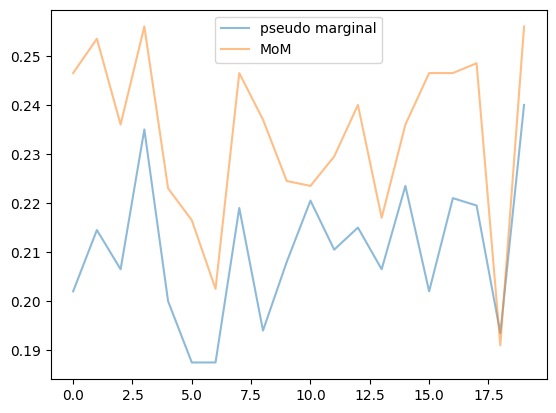

In [5]:
import matplotlib.pyplot as plt

plt.plot(all_acceptance_rates, alpha=.5, label='pseudo marginal')
plt.plot(all_acceptance_rates_mom, alpha=.5, label='MoM')
plt.legend()
plt.show()

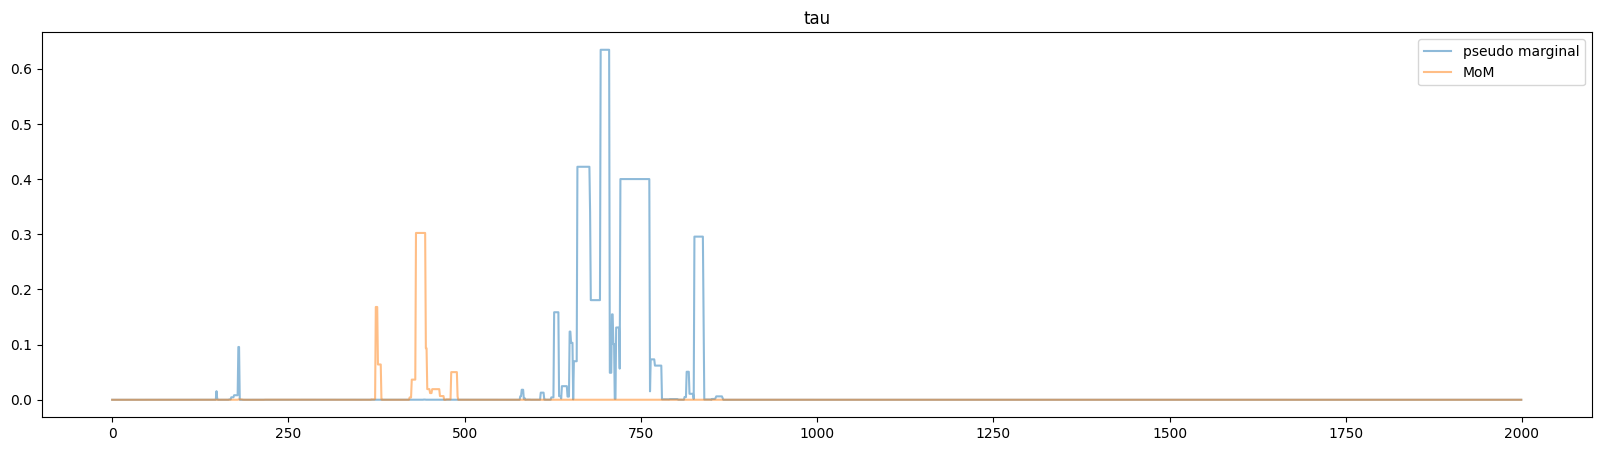

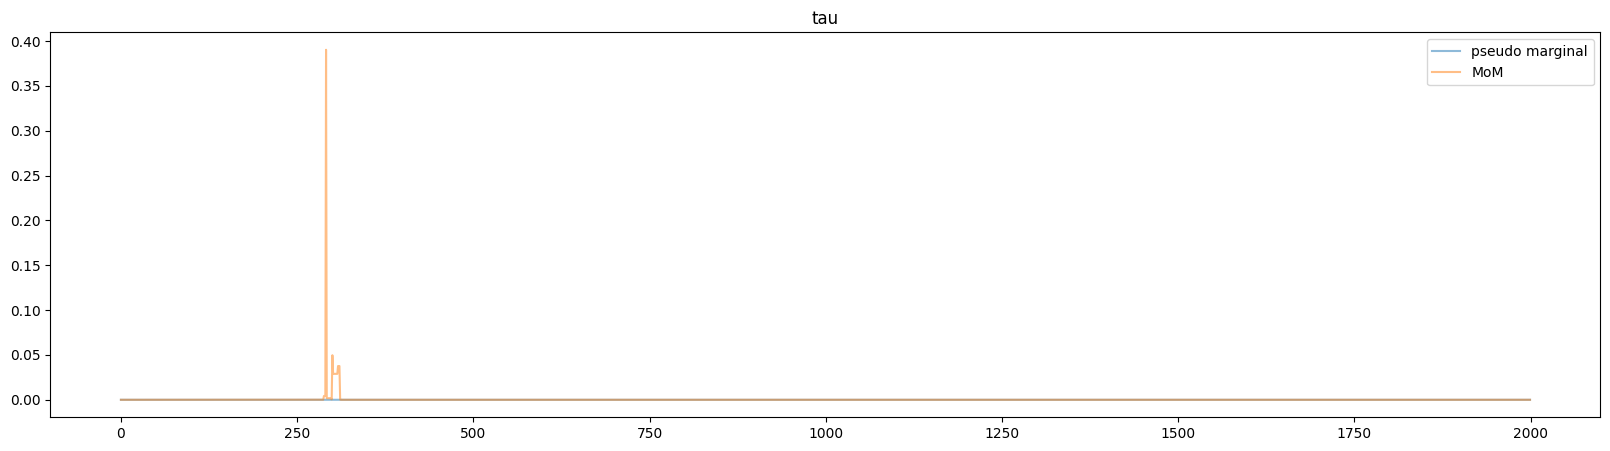

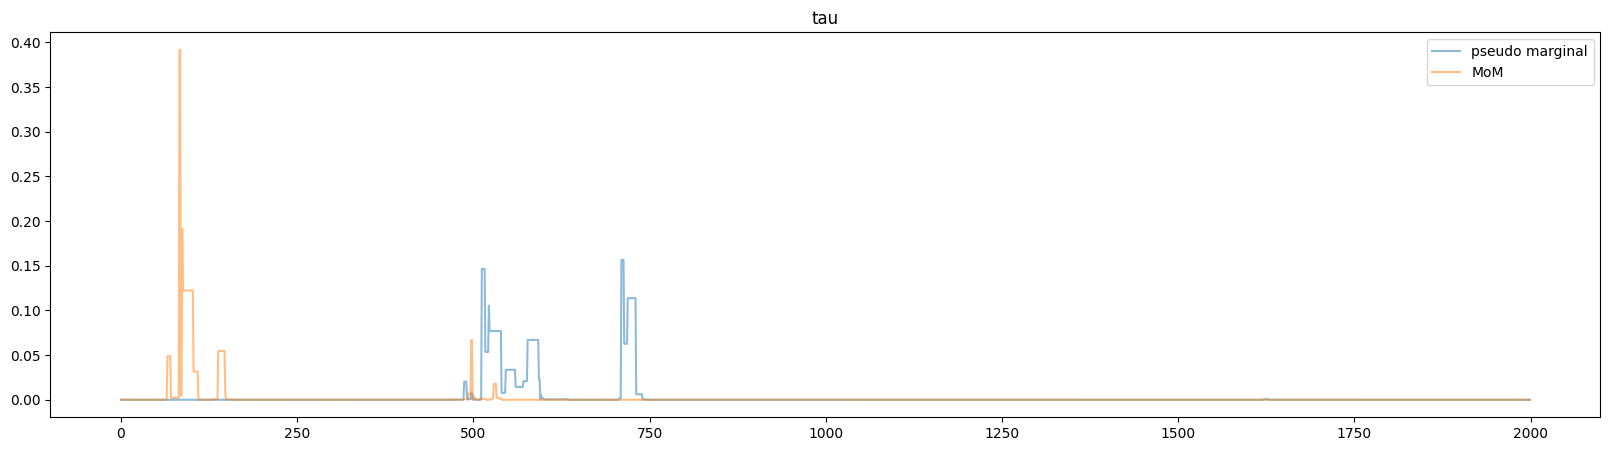

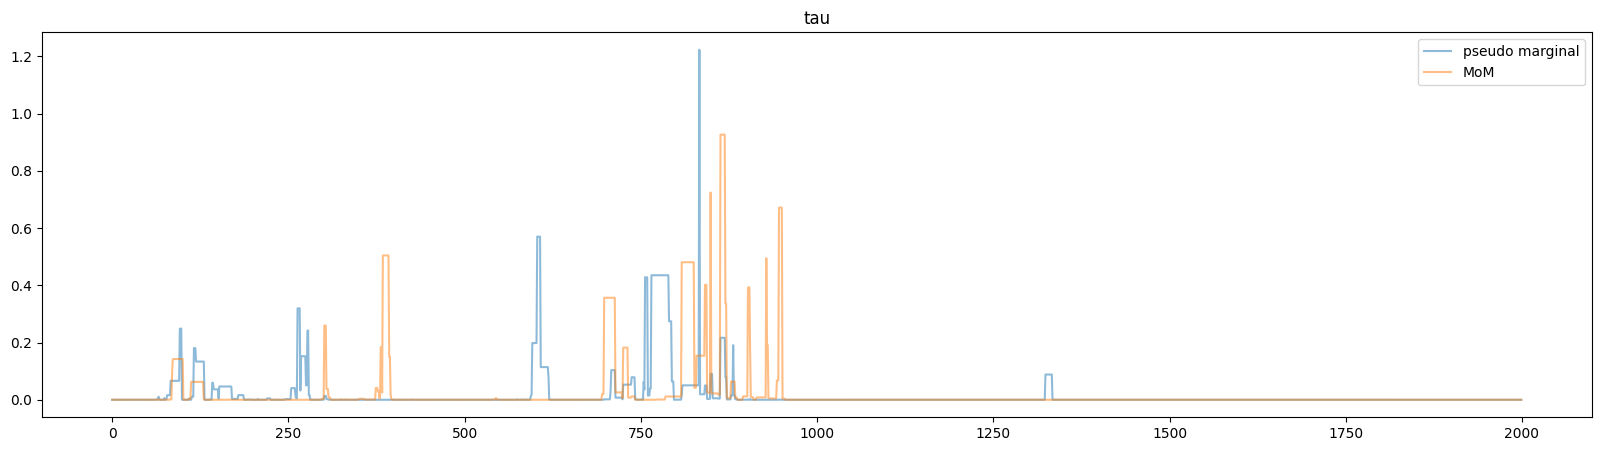

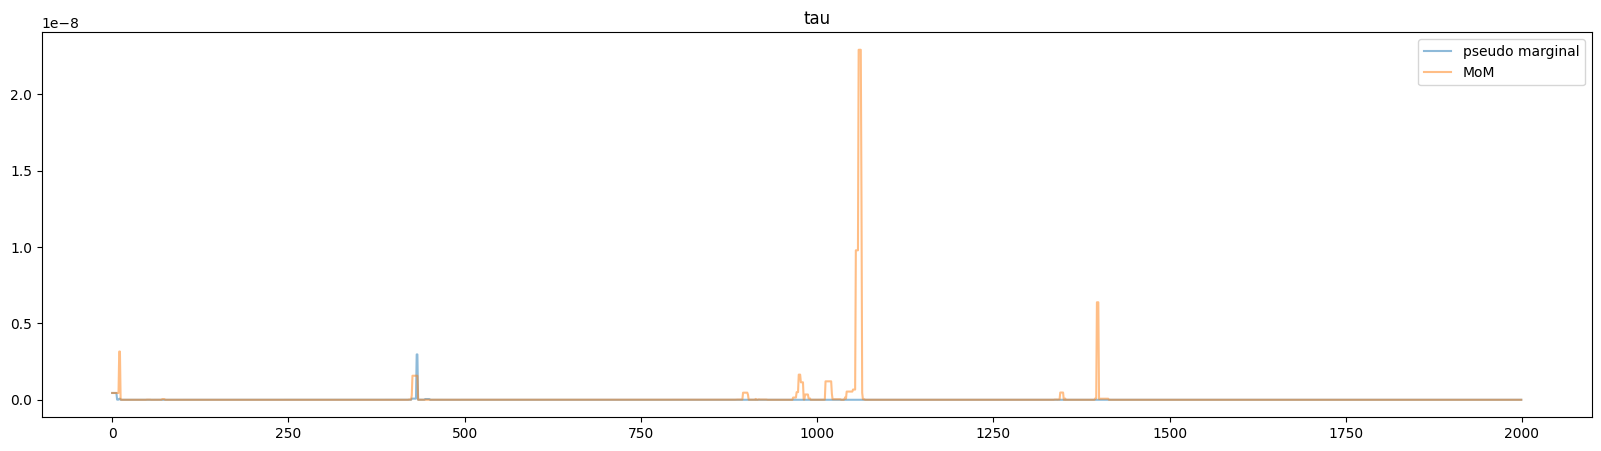

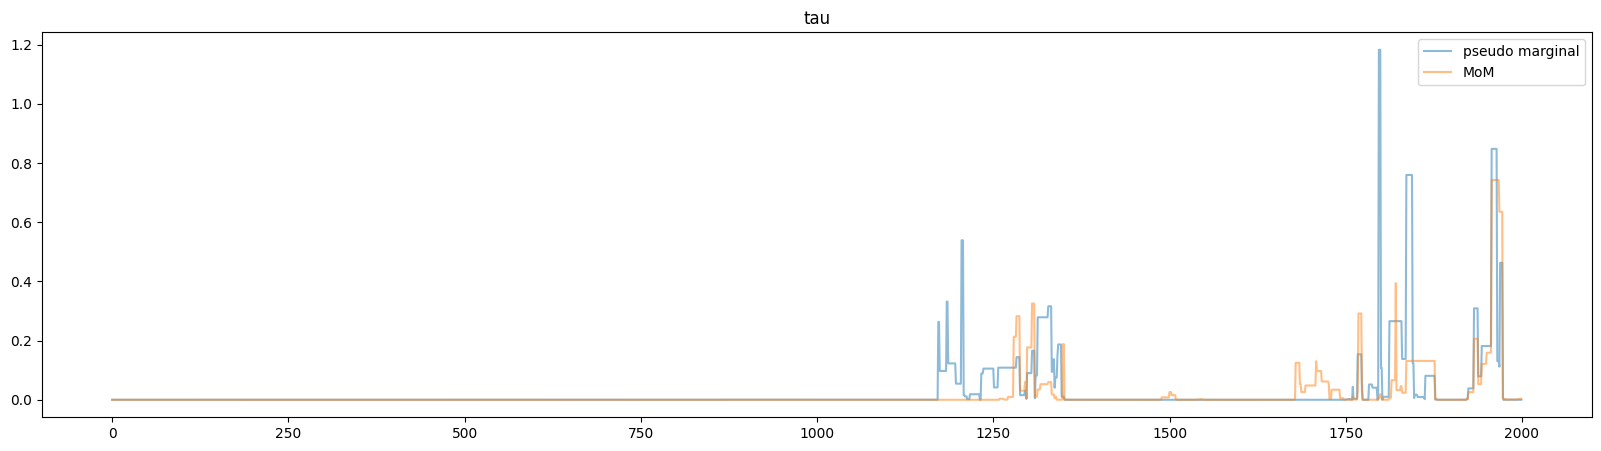

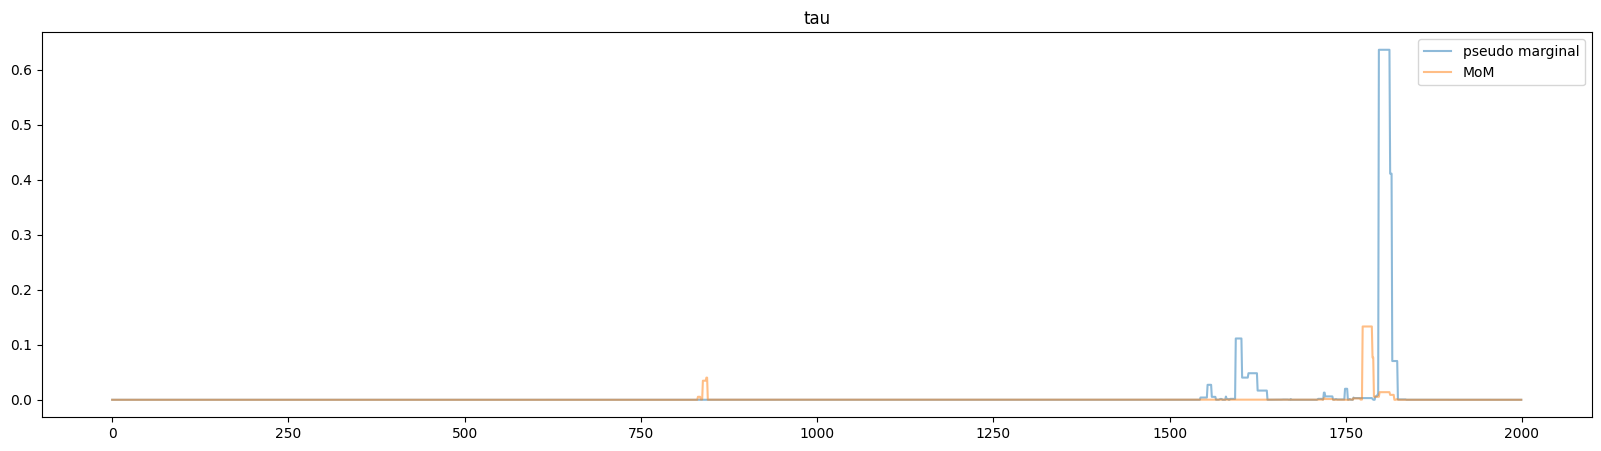

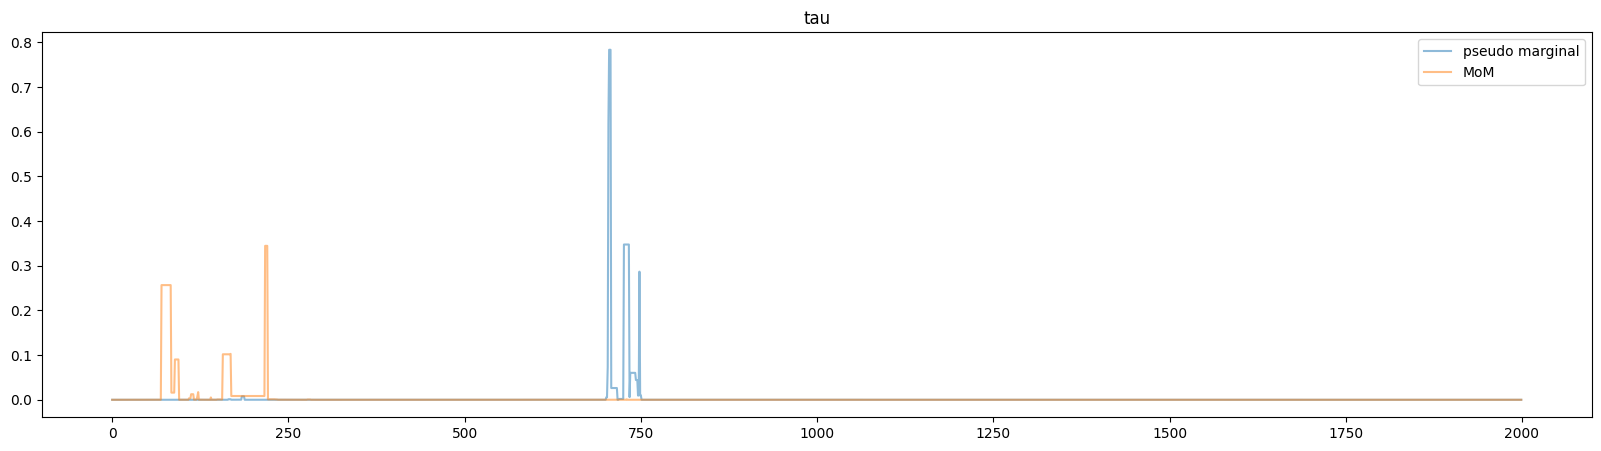

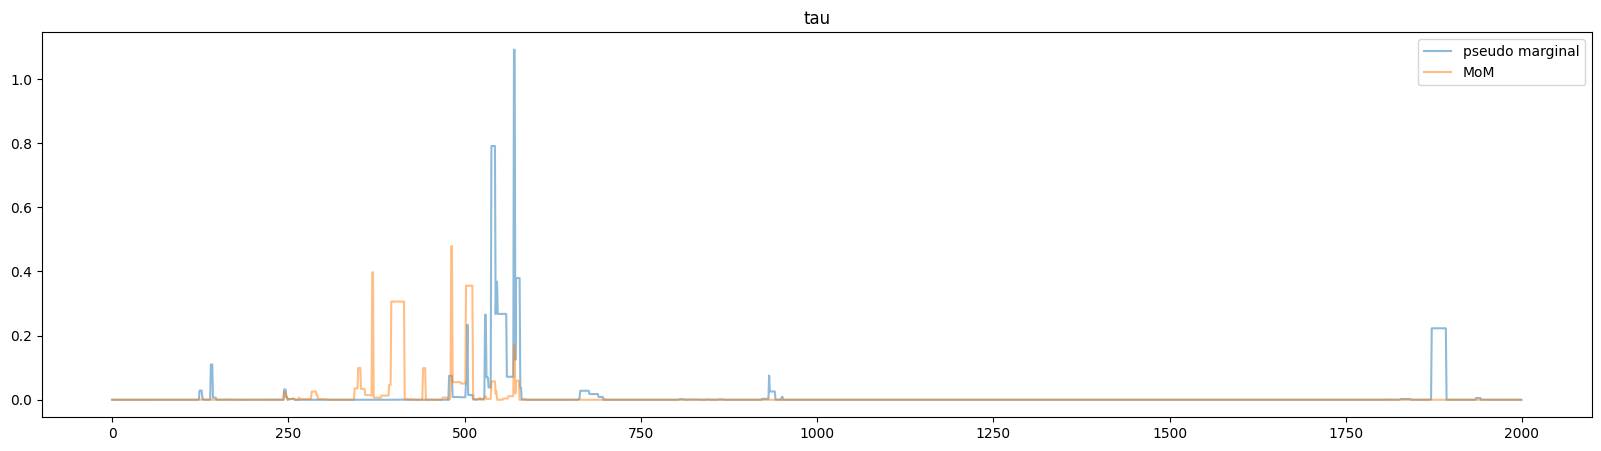

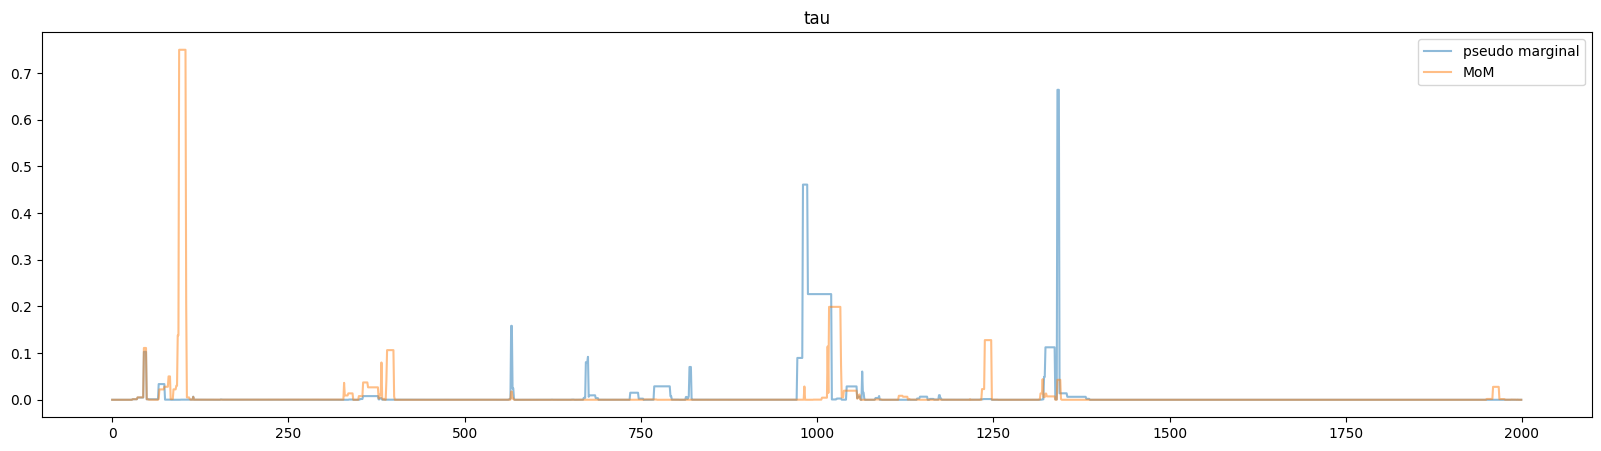

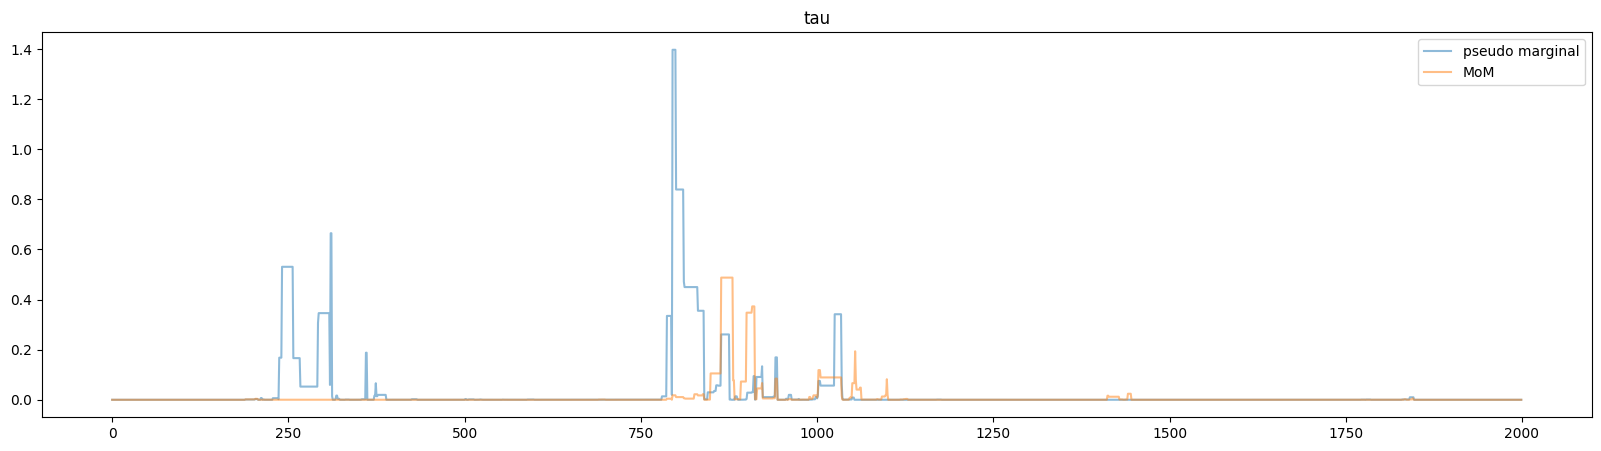

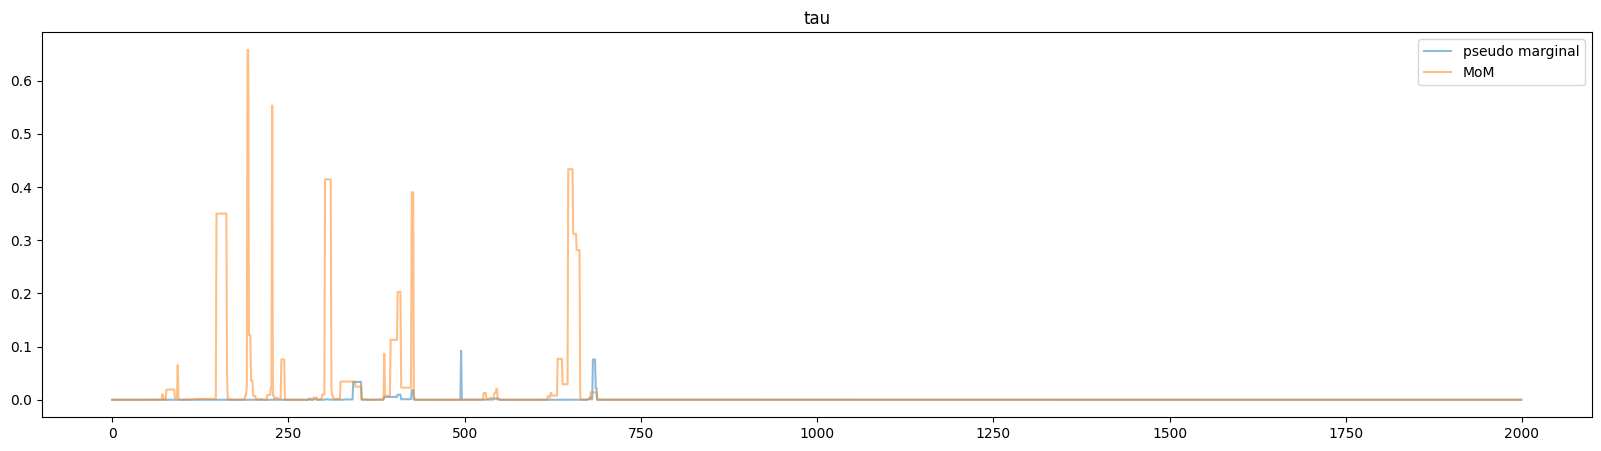

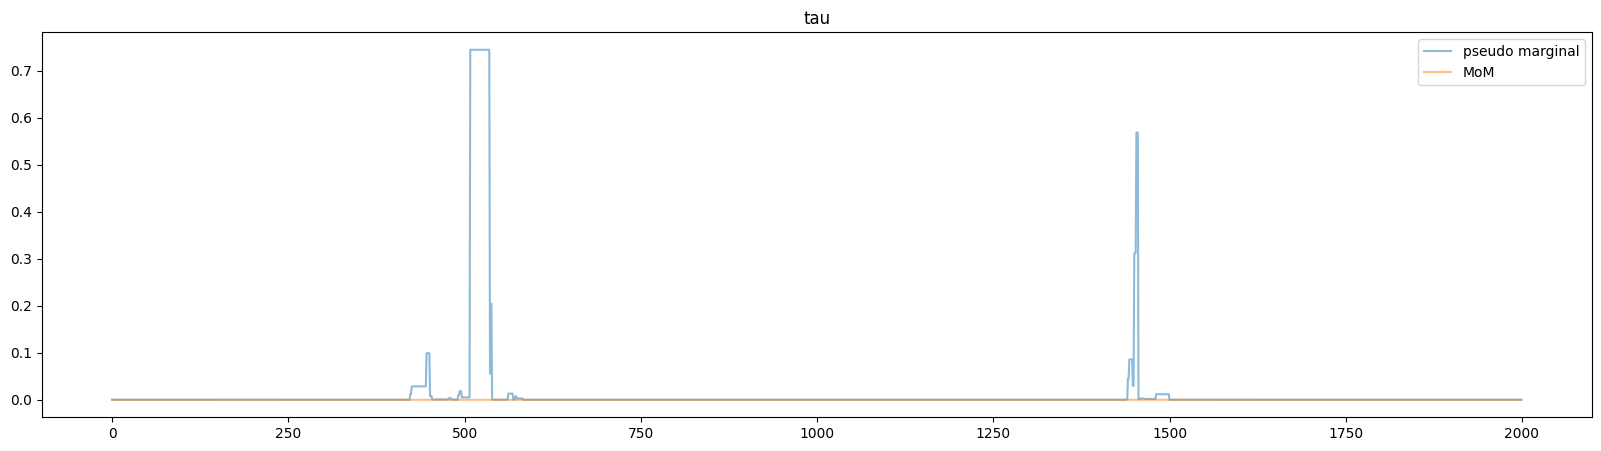

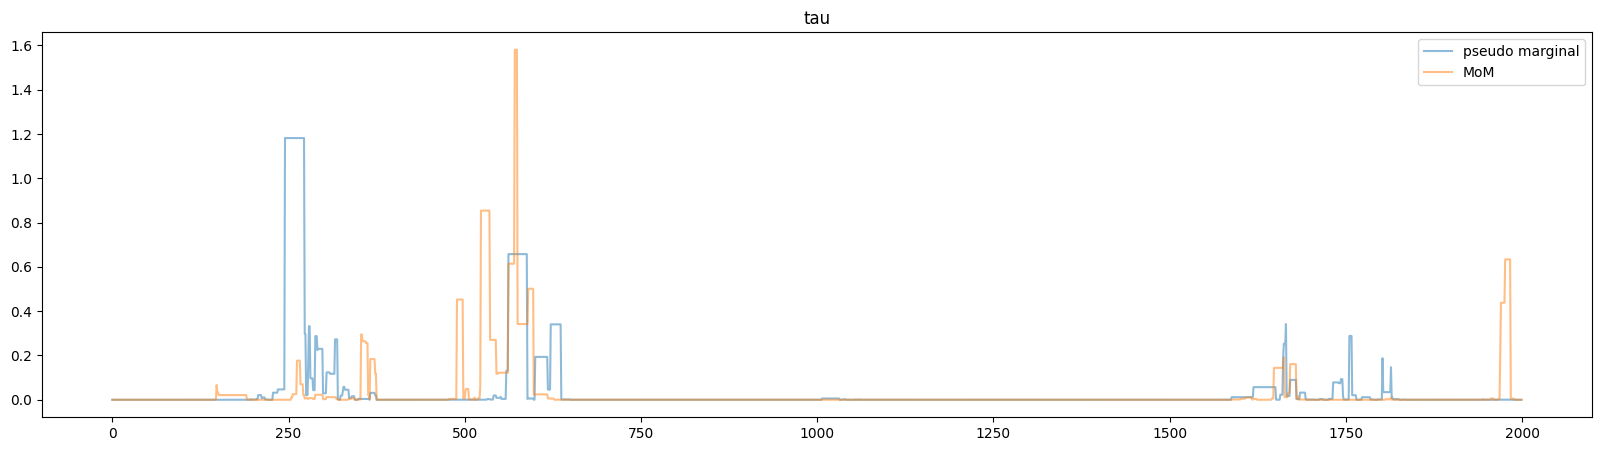

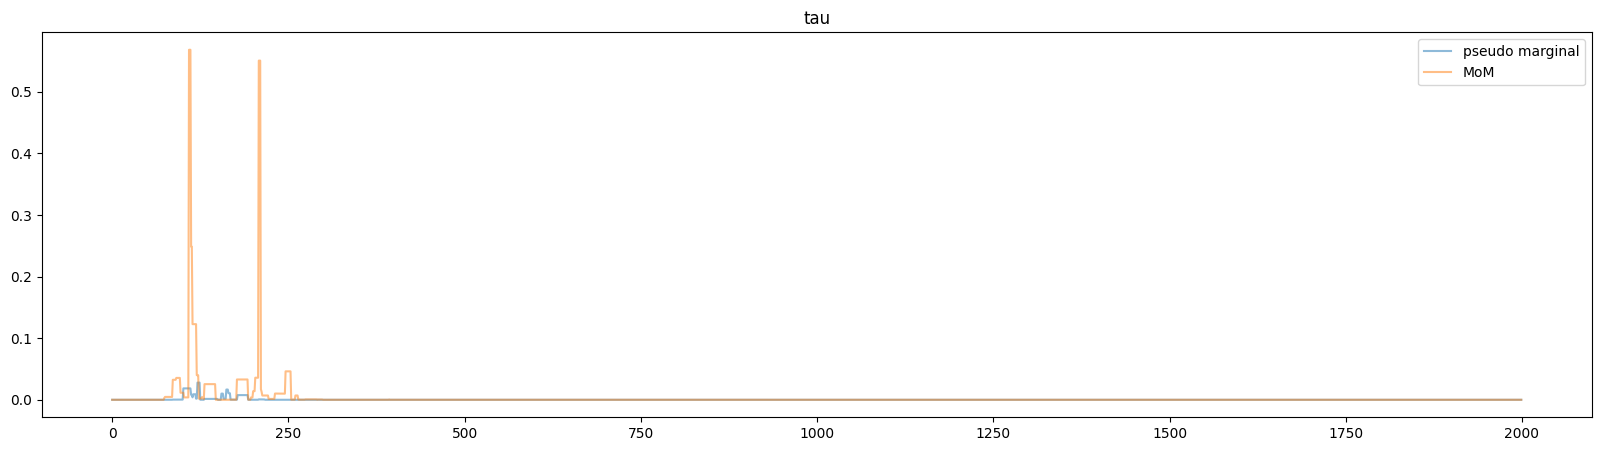

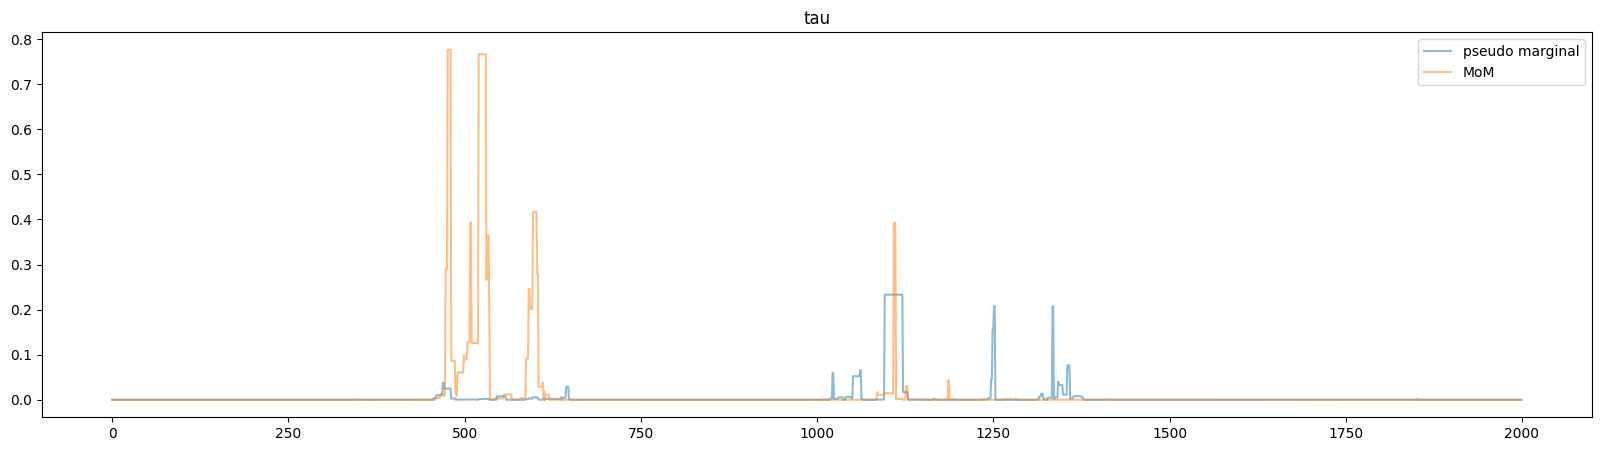

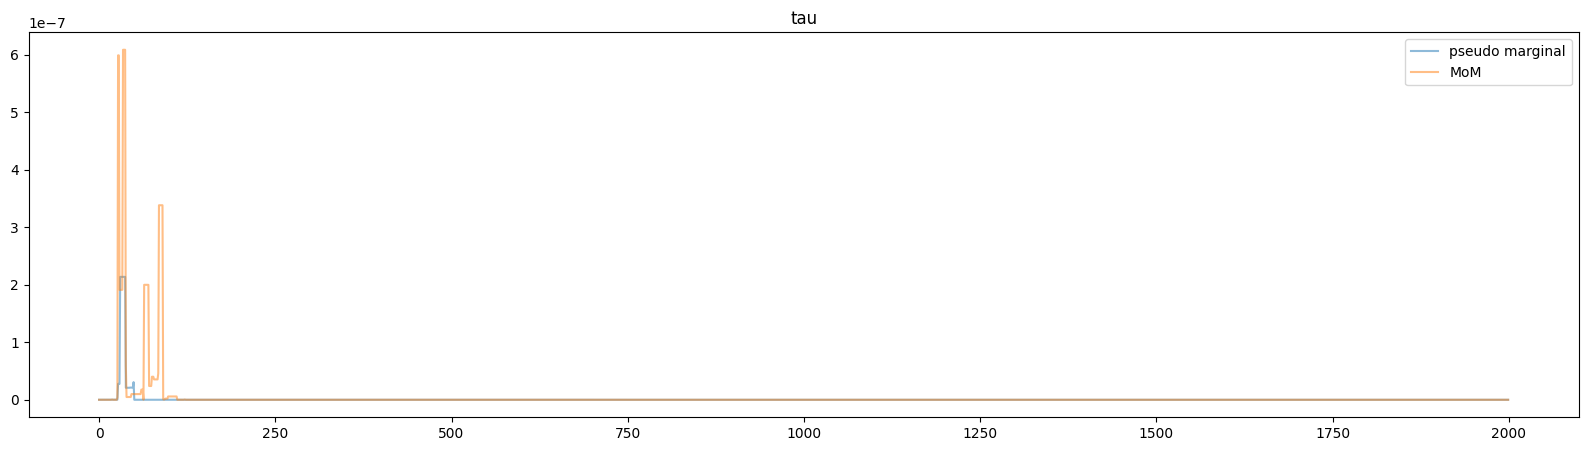

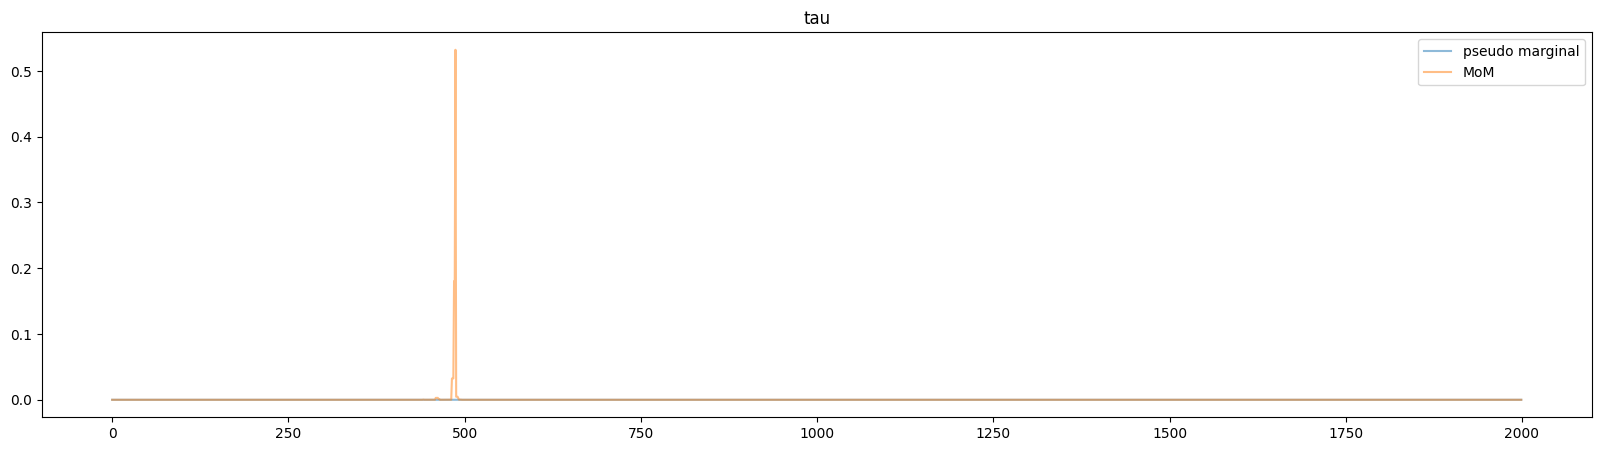

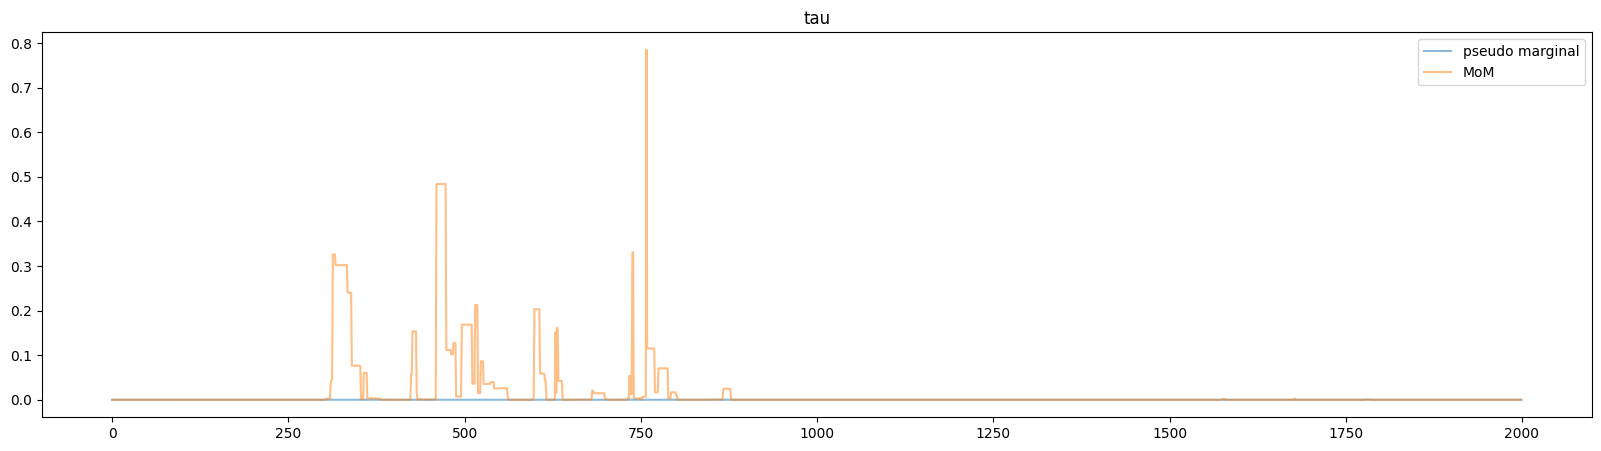

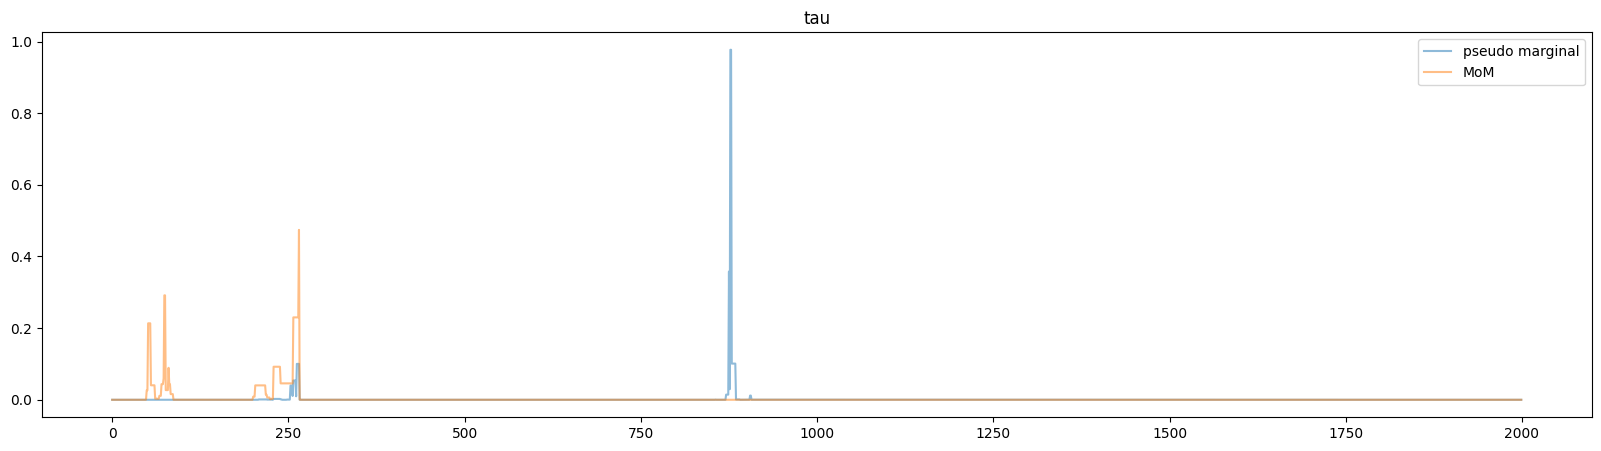

In [7]:
n_chains = 20

for i in range(n_chains):
    plt.subplots(figsize=(20, 5))
    plt.plot(all_thetas[i][:,:,0], alpha=.5, label='pseudo marginal')
    plt.plot(all_thetas_mom[i][:,:,0], alpha=.5, label='MoM')
    plt.legend()
    plt.title('tau')
    plt.show()